# ANN: Regression (Website Traffic)

## Imports

First we do all installations and imports

In [2]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

## Loads and process data

The csv file is loaded and we check the columns

In [3]:
df = pd.read_csv("./Data/website_data.csv")

In [4]:
df.columns

Index(['Page Views', 'Session Duration', 'Bounce Rate', 'Traffic Source',
       'Time on Page', 'Previous Visits', 'Conversion Rate'],
      dtype='object')

Now we exclude Conversion Rate. We will now try to use Time on Page as target.

In [5]:
df = df[['Page Views', 'Session Duration', 'Bounce Rate',
       'Time on Page', 'Previous Visits']]

With the code below, we try to take care of possble outliers from the dataframe

In [6]:
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [7]:
df.head()

,Page Views,Session Duration,Bounce Rate,Time on Page,Previous Visits
0,5,11.051381,0.230652,3.890460,3
1,4,3.429316,0.391001,8.478174,0
2,4,1.621052,0.397986,9.636170,2
3,5,3.629279,0.180458,2.071925,3
4,5,4.235843,0.291541,1.960654,5


## X en y-variabelen definieren

In [8]:
X = df[['Page Views', 'Bounce Rate', 'Previous Visits', 'Session Duration']]
# X = df[['Bounce Rate', 'Time on Page',
#         'Previous Visits', 'Conversion Rate']]
y = df[['Time on Page']]

## Optimal variables

We want to optimize the selection of used variables in the ANN. We use a correlation table to visualise the correlation between every variable. The correlations are a number between -1 and 1, high correlations can cause redundancy => overfitting, ineficiency, ... So the point of doing the following step is to see if we can leave one or more higly correlated variables behind before proceeding to the ANN

In [9]:
# !pip install pandasgui
from pandasgui import show

correlations = df.corr()
show(correlations)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
C:\Users\ruben\AppData\Local\Temp\ipykernel_31780\1652946242.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  show(correlations)
C:\Users\ruben\AppData\Local\Temp\ipykernel_31780\1652946242.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  show(correlations)
C:\Users\ruben\AppData\Local\Temp\ipykernel_31780\1652946242.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users

We can see from the grid that there's no significant correlation between variables

Now in the next code part, let's go over feature importance using KBest selection

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
3,Session Duration,53.16
2,Previous Visits,9.39
0,Page Views,8.08
1,Bounce Rate,NaN


From this output we can conclude that Session Duration and Time on Page are the two most important features who have the stronges relation with the target variable => Conversion Rate. It is weird that Bounce Rate gets a NaN.

In [11]:
print(df['Bounce Rate'].isnull().sum())
print(df['Bounce Rate'].nunique())
# No weird output so that's strange...

0
1907


## Test/train/validation-split

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

## Neural Network

Now the fun part... creating the model. I started with a simple model with 3 layers, but the results were very bad. I tried a lot of different combinations, and even added Dropout layers, but the metrics are still very bad. We set the target variable to be "Conversion Rate", so that's the one we're predicting

In [27]:
model = keras.Sequential(
    [
        layers.Dense(8, activation="relu", input_shape=(4,)),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mse')

model.summary()

C:\Users\ruben\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,873 (50.29 KB)

 Trainable params: 12,873 (50.29 KB)

 Non-trainable params: 0 (0.00 B)

## Start training of NN

In [28]:
model.fit(x=X_train, y=y_train, epochs=400, validation_data=(X_val, y_val))

Epoch 1/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.6241 - val_loss: 10.7654
Epoch 2/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3107 - val_loss: 9.8502
Epoch 3/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3629 - val_loss: 10.1961
Epoch 4/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2940 - val_loss: 10.1970
Epoch 5/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7539 - val_loss: 10.4964
Epoch 6/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1897 - val_loss: 10.1101
Epoch 7/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6974 - val_loss: 9.0761
Epoch 8/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5019 - val_loss: 8.8493
Epoch 9/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5635 - val_loss: 9.1587
Epoch 10/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4056 - val_loss: 8.7024
Epoch 11/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2172 - val_loss: 8.6728
Epoch 12/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3065 - val_loss: 6.8711
Epoch 70/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5284 - val_loss: 6.8706
Epoch 71/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2135 - val_loss: 6.8934
Epoch 72/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7425 - val_loss: 6.8524
Epoch 73/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3163 - val_loss: 6.8269
Epoch 74/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3417 - val_loss: 6.8477
Epoch 75/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3855 - val_loss: 6.8599
Epoch 76/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5866 - val_loss: 6.8412
Epoch 77/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6764 - val_loss: 6.8514
Epoch 78/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6214 - val_loss: 6.8640
Epoch 79/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4355 - val_loss: 6.8862
Epoch 80/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6557 

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3857 - val_loss: 6.9227
Epoch 138/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3393 - val_loss: 6.8754
Epoch 139/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1023 - val_loss: 6.9474
Epoch 140/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6175 - val_loss: 6.8987
Epoch 141/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4253 - val_loss: 6.8789
Epoch 142/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5635 - val_loss: 6.9013
Epoch 143/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4703 - val_loss: 6.9008
Epoch 144/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5062 - val_loss: 6.8992
Epoch 145/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8175 - val_loss: 6.8891
Epoch 146/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7419 - val_loss: 6.8772
Epoch 147/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3857 - val_loss: 6.8853
Epoch 148/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

Epoch 205/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7027 - val_loss: 6.9164
Epoch 206/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4911 - val_loss: 6.8973
Epoch 207/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5128 - val_loss: 6.9124
Epoch 208/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0790 - val_loss: 6.9045
Epoch 209/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5794 - val_loss: 6.9008
Epoch 210/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6135 - val_loss: 6.8998
Epoch 211/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3724 - val_loss: 6.9091
Epoch 212/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5193 - val_loss: 6.9331
Epoch 213/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4672 - val_loss: 6.9201
Epoch 214/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0066 - val_loss: 6.9441
Epoch 215/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5104 - val_loss: 6.9353
Epoch 216/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8059 - val_loss: 6.8794
Epoch 273/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1688 - val_loss: 6.9068
Epoch 274/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5657 - val_loss: 6.8945
Epoch 275/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1934 - val_loss: 6.8815
Epoch 276/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8039 - val_loss: 6.8993
Epoch 277/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3124 - val_loss: 6.9066
Epoch 278/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6949 - val_loss: 6.9226
Epoch 279/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1131 - val_loss: 6.9347
Epoch 280/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0912 - val_loss: 6.9362
Epoch 281/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6355 - val_loss: 6.9294
Epoch 282/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9063 - val_loss: 6.9269
Epoch 283/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

Epoch 340/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7322 - val_loss: 6.9543
Epoch 341/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2217 - val_loss: 6.9477
Epoch 342/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2058 - val_loss: 6.9552
Epoch 343/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2406 - val_loss: 6.9621
Epoch 344/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9452 - val_loss: 6.9833
Epoch 345/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2124 - val_loss: 6.9739
Epoch 346/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8507 - val_loss: 6.9746
Epoch 347/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4601 - val_loss: 6.9766
Epoch 348/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9878 - val_loss: 6.9683
Epoch 349/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1013 - val_loss: 6.9967
Epoch 350/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3996 - val_loss: 6.9632
Epoch 351/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

## Training error metrics

<AxesSubplot:>

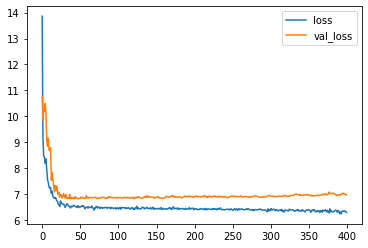

In [29]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Test/training data eval

In [30]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
6.6275506019592285

Train data evaluation:
6.2826762199401855


## Get test predictions for evaluation metrics

In [31]:
test_predictions = model.predict(X_test)

test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']


pred_df

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Test True Y,Model Predictions
0,5.39,3.74
1,5.99,3.73
2,3.28,3.75
3,1.41,4.17
4,2.63,3.94
...,...,...
282,2.49,4.46
283,3.10,3.83
284,1.67,3.74
285,2.35,3.73


## Metrics

<AxesSubplot:xlabel='Test True Y', ylabel='Model Predictions'>

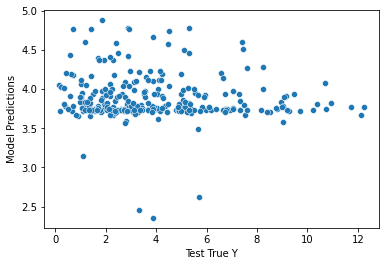

In [32]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

## Error regression metrics

In [33]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "sec")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "sec^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "sec")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
2.04 sec

MSE
6.63 sec^2

RMSE:
2.57 sec

R-squared:
-0.03

Explained variance score:
-0.03


As we see real bad results. We've already tried a lot of combinations of layers and nodes...

<AxesSubplot:xlabel='Bounce Rate', ylabel='Count'>

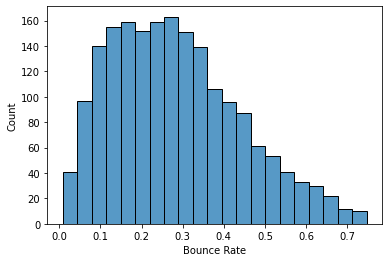

In [34]:
sns.histplot(df['Bounce Rate'])

<AxesSubplot:xlabel='Page Views', ylabel='Count'>

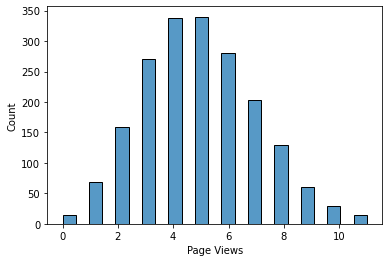

In [35]:
sns.histplot(df['Page Views'])

<AxesSubplot:xlabel='Previous Visits', ylabel='Count'>

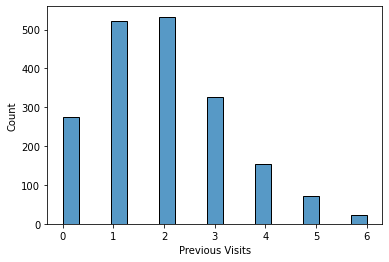

In [36]:
sns.histplot(df['Previous Visits'])

<AxesSubplot:xlabel='Session Duration', ylabel='Count'>

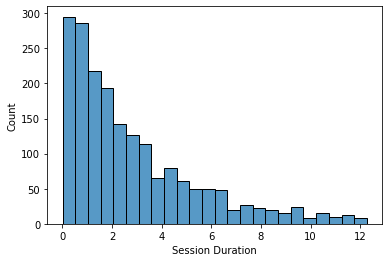

In [38]:
sns.histplot(df['Session Duration'])

<AxesSubplot:xlabel='Time on Page', ylabel='Count'>

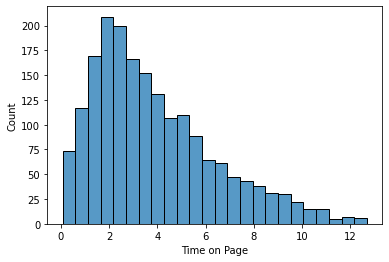

In [39]:
sns.histplot(df['Time on Page'])